# Working with data from simulations

In cosmological simulations it is very typical to have massive particles that represent a single stellar population with a given age and metallicity. In order to compare predictions from these simulations with observational data it is ofter required to convert from these quantities to flux, magnitudes or surface brightness. In this example, we explore how to do this with milespy with an example simulated galaxy.

In [1]:
from astropy import units as u
from astropy.visualization import quantity_support
quantity_support()
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np

We load the data from a simple ASCII files with the basic information that we need.
We mask the data that is not of interest and we trim the age information, as the library does not contain SSP with ages < 0.6 Gyr and thus will throw errors.

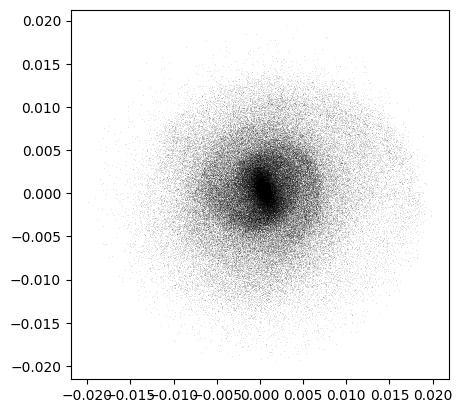

In [2]:
x,y,z,mass,met,age = np.loadtxt('stars.txt', unpack=True)
m = np.logical_and(~np.isnan(age), np.sqrt(x**2+y**2+z**2) < 0.02)
x = x[m]
y = y[m]
z = z[m]
mass = mass[m] << u.Msun
met = met[m] << u.dex
tage = age[m]
tage[tage<0.0631] = 0.0631
age = tage << u.Gyr

plt.plot(x,y, 'k,', alpha=0.1)
plt.gca().set_aspect('equal')

For this exercise we will use the EMILES SSP library

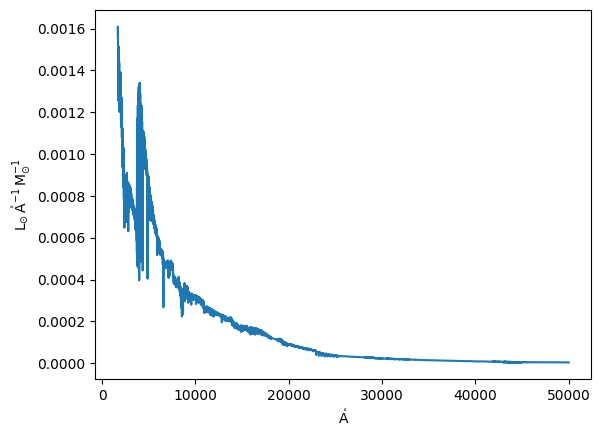

In [3]:
from milespy import SSPLibrary
lib = SSPLibrary(source='EMILES_SSP')
plt.plot(lib.models.spectral_axis, lib.models[10].flux)

However, we do not require all the spectral range for this analysis. Thus, we trim the models to the region of interest. Note that not doing this could cause a **very large** memory allocation, as there are ~50000 spectral points and ~150000 particles, resulting in ~60 GB of required RAM! If you really need the full spectral range, you could perform the following analysis in batches of particles to make it more manageable for your system.

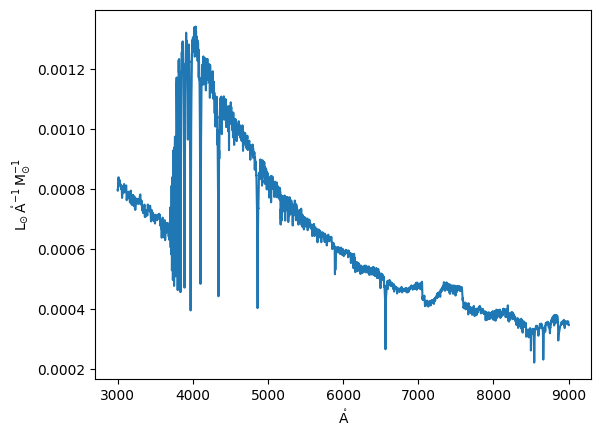

In [4]:
lib.trim(3000.*u.AA, 9000*u.AA)
plt.plot(lib.models.spectral_axis, lib.models[10].flux)

If this is still not enough of you do not need the spectral resolution, you can also resample the whole library.

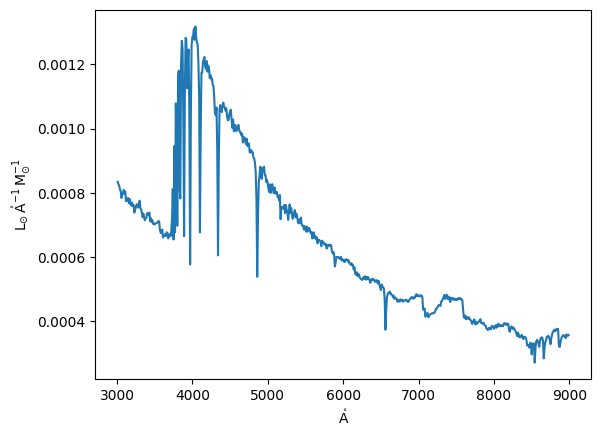

In [5]:
lib.resample(np.arange(3010, 9000, 10)<<u.AA)
plt.plot(lib.models.spectral_axis, lib.models[10].flux)

We decide to use `closest` as it is way faster than `interpolate` and having 150000 particles we can assume that the mean deviations will be small... but that is something you must consider carefully!

In [6]:
%time specs = lib.closest(age=age, met=met, imf_slope=np.full(met.shape, 1.3), mass=mass)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 143398/143398 [00:04<00:00, 28841.25it/s]


CPU times: user 5.22 s, sys: 190 ms, total: 5.41 s
Wall time: 5.25 s


As a side note, you can save and restore the generated spectra as shown in the cell below if you do not want to repeat the costly interpolation all the time.

In [7]:
#np.savez('all', flux=specs.flux.value, wave=specs.spectral_axis.value)
#loaded = np.loadz('all')
#flux = u.Quantity(loaded['flux'], unit=u.L_sun / u.AA)
#wave = u.Quantity(loaded['wave'], unit=u.AA)
#specs = spectra(flux=flux, spectral_axis=wave)

## Taking into account line-of-sight velocities

In simulations, the velocity information of each SSP is also accesible, thus we can take this into account in the generated spectras.
We can compute, for example, the spectra of the galaxy with and without the velocity shifts.

Note that as we resampled above the spectra to a resolution of 10 $\unicode{x212B}$, velocity shifts of less than 500 km/s will be hard to be resolved (although the shift itself is performed).

As in this case we did not store velocity information in the file to make it smaller, we can make a simple (yet unphysical) assumption about the velocity distribution:


In [8]:
v_los = np.random.normal(loc=0, scale=500, size=specs.nspec) << (u.km/u.s)

and then create new spectra with this velocity shift.

In [9]:
shifted = specs.velocity_shift(v_los)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 143398/143398 [00:14<00:00, 9777.13it/s]


We can then compute the spectra of the galaxy as a whole, and compare it to the spectra obtained without velocity information.

(<matplotlib.patches.Rectangle at 0x701dced870a0>,
 (<matplotlib.patches.ConnectionPatch at 0x701d9e1a9d50>,
  <matplotlib.patches.ConnectionPatch at 0x701d9e1aa920>))

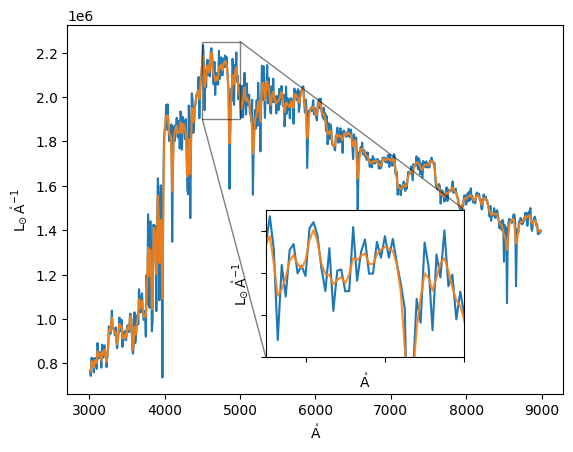

In [10]:
galaxy_spectrum = specs.sum(axis=0)
galaxy_spectrum_los = shifted.sum(axis=0)

plt.plot(galaxy_spectrum.spectral_axis, galaxy_spectrum.flux)
plt.plot(galaxy_spectrum_los.spectral_axis, galaxy_spectrum_los.flux, alpha=0.9)

x1, x2, y1, y2 = 4500, 5000, 1.9e6, 2.25e6  # subregion of the original image
axins = plt.gca().inset_axes(
    [0.4, 0.1, 0.4, 0.4],
    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
axins.plot(galaxy_spectrum.spectral_axis, galaxy_spectrum.flux)
axins.plot(galaxy_spectrum_los.spectral_axis, galaxy_spectrum_los.flux, alpha=0.9)

plt.gca().indicate_inset_zoom(axins, edgecolor="black")


As this is simple Gaussian velocity distribution and at rather low spatial resolution, the difference is just a subtle smoothing of the spectra. But this example can be the basis for more advanced investigations.

## Building a spectral cube

As we have a spectrum per particle, it could be of interest to build a spectral cube, where we sum the contribution of all particles in a given bin (weighted by their mass).
For this, we first define the binning configuration and we used `binned_statistic_2d` to get the bin to which each particle belongs.

In [11]:
from scipy.stats import binned_statistic_2d

nbins = 100
bins = np.linspace(-0.02,0.02,nbins)
_, xed, yed, nn = binned_statistic_2d(x, y, mass, statistic='sum', bins=bins, expand_binnumbers=True)               

Then we create an empty spectral cube and we start summing the contribution to each bin

In [12]:
from milespy.spectra import Spectra

cube = Spectra(spectral_axis=specs.spectral_axis, flux=u.Quantity(np.zeros((nbins+1,nbins+1,specs.npix)), unit=specs.flux.unit))                        
for i,(xx,yy) in enumerate(nn.T):                                                                                                         
    cube.data[xx,yy,:] += specs.data[i, :] 

We compute the zero moment (i.e., intensity) of the whole cube

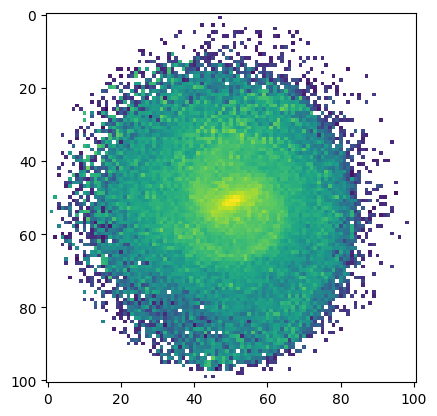

In [13]:
from specutils.analysis import moment

mom = moment(cube, order=0)
plt.imshow(mom.value, norm=LogNorm())

## Spectral regions

Using `spectral_slab` we can take a look at specific part of the spectra for its analysis

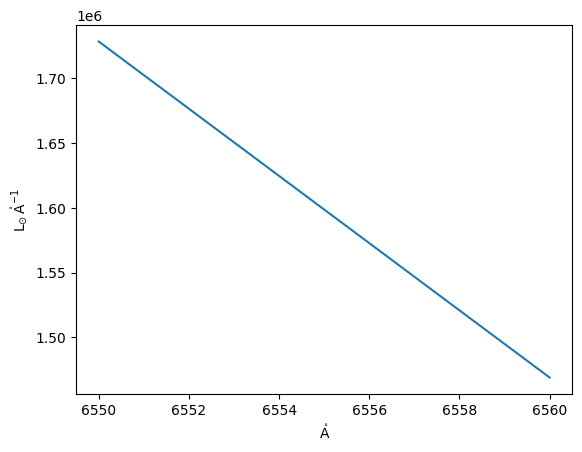

In [14]:
from specutils.manipulation import spectral_slab

subspec = spectral_slab(cube, 6560.*u.AA, 6550*u.AA)
ha_flux = np.sum(subspec.flux, axis=(0,1))
plt.plot(subspec.spectral_axis, ha_flux)

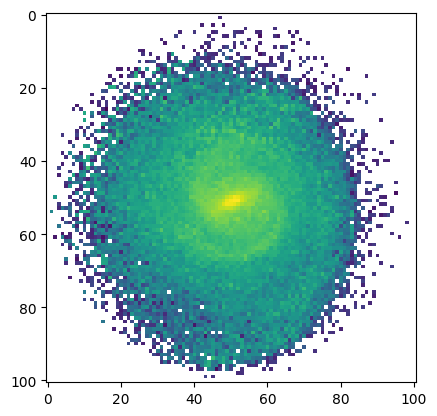

In [15]:
ha_mom = moment(subspec, order=0)
plt.imshow(ha_mom.value, norm=LogNorm())

## Magnitudes

We are going to compute the `i`, `g` and `r` magnitudes of the galaxy, assuming that it is at a distance of 10 Mpc

In [16]:
import milespy.filter as flib

fnames = flib.search("OAJ_JPAS.(iSDSS|gSDSS|rSDSS)")
filts = flib.get(fnames)
abs_mags = cube.magnitudes(filters=filts)

In [17]:
d = 10 * u.Mpc
distance_modulus = 5 * np.log10( d.to(u.pc)/(10*u.pc) ) - 5
mags = {k: (abs_mags[k] + distance_modulus) for k in abs_mags.keys()}

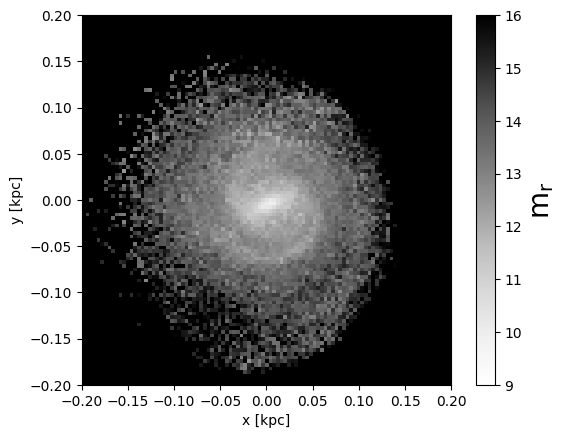

In [18]:
plt.imshow(mags['OAJ_JPAS.rSDSS'], cmap='Greys', vmin=9, vmax=16, extent=(-0.2, 0.2, -0.2, 0.2))
plt.gca().set_facecolor("k")
plt.xlabel('x [kpc]')
plt.ylabel('y [kpc]')
cbar = plt.colorbar().set_label(r'm$_\mathrm{r}$', fontsize=20)


A color map can also be obtained

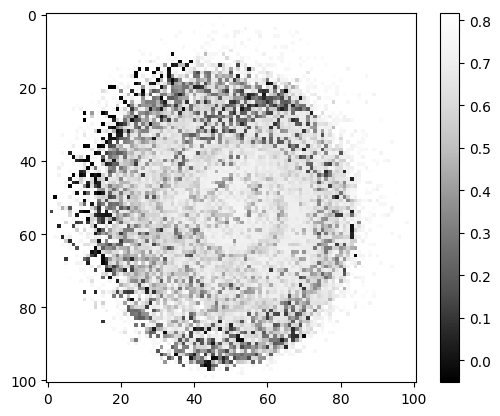

In [19]:
plt.imshow(mags['OAJ_JPAS.gSDSS']-mags['OAJ_JPAS.rSDSS'], cmap='Greys_r')
plt.colorbar()

## False-color image

Lastly, with some tinkering, the magnitude maps can be combined to create a false-color image. However, there is no fixed way to approach this. In our case we renormalize each filter independently.

In [20]:
def norm(f):
    mask = np.isfinite(f)
    minf = f[mask].min()
    maxf = f[mask].max()
    f[mask] = (f[mask] - minf)/(maxf-minf)
    return 1-1.4*f

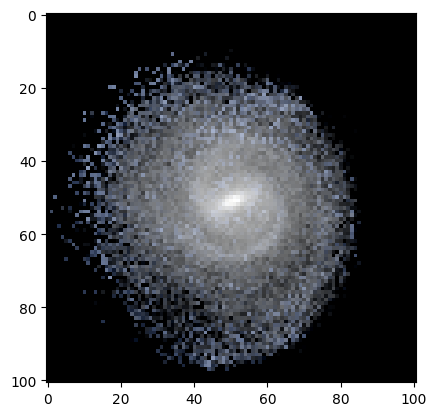

In [21]:
r = norm(mags['OAJ_JPAS.iSDSS'])
g = norm(mags['OAJ_JPAS.rSDSS'])
b = norm(mags['OAJ_JPAS.gSDSS'])
rgb = np.dstack((r,g,b))
plt.imshow(rgb)

But there are other stablished tools in astropy, for example. However, these also required some parameter tuning to get a nice-looking image...

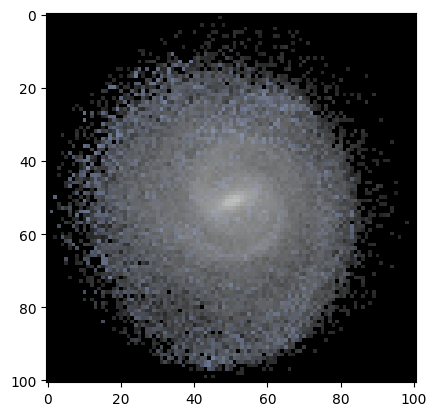

In [22]:
from astropy.visualization import make_lupton_rgb
rgb_default = make_lupton_rgb(10**(-mags['OAJ_JPAS.iSDSS']), 10**(-mags['OAJ_JPAS.rSDSS']), 10**(-mags['OAJ_JPAS.gSDSS']), stretch=0.8, Q=2.5)
plt.imshow(rgb_default)